## Exploring Simband data, full upload, 061418

In [1]:
import os, os.path
import pandas as pd
import glob
import datetime
import json
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

In [3]:
path = os.getcwd()
files = os.listdir(path)
files.remove('.DS_Store')
files.remove('.ipynb_checkpoints')
files.remove('SimBand_Initial_Exploration.ipynb')

In [4]:
file_dict = {}
for file in files:
    file = file
    num_files = len(glob.glob('{}/*'.format(file)))
    file_dict[file] = num_files

### Opening and concatenating the data for all patients

In [ ]:
# open the zipped tar files and save to patient directory

import tarfile

for file in files:
    contents = (glob.glob('{}/*'.format(file)))
    for item in contents:
        if (str(item[-3:]) == 'tgz'):
            path = (item.split('/')[0])
            name = (item.split('/')[1])
            with tarfile.open(item) as tar:
                print(name)
                tar.extractall(path=path)

In [5]:
# function to concatenate specific test type within patient subdirectories

def concat_test_files(input_test_file_name, patient_files_list): # takes keyword input for test name
    df_list = []
    for file in patient_files_list:
        contents = (glob.glob('{}/*'.format(file)))
        for item in contents:
            if (str(item[-3:]) == 'csv'):
                if (item.find(input_test_file_name) > 0):
                    temp_df = pd.DataFrame.from_csv(item)
                    df_list.append(temp_df)

    output_df = pd.concat(df_list, ignore_index=True)
    return(output_df)

In [6]:
# creating df for reaction tests

go_no_go = concat_test_files('Go No Go', files)
simp_rxn_time = concat_test_files('Simple Reaction Time', files)
proc_rxn_time = concat_test_files('Procedural Reaction Time', files)

In [8]:
# function to filter csv file by keyword before writing to df

import csv
import re

def filter_simband_csv(input_file, valid_string_list): # takes input file and list of fields of interest
    with open(input_file, 'r') as f_in:
        with open('output_file', 'w') as f_outfile:
            # define header column
            f_outfile.write("ts,cts,ddid,sdid,sdtid,mid,mv,uid,data\n")       
            for line in f_in:
                for search_str in valid_string_list:
                    if bool(re.search(search_str, line)):
                        f_outfile.write(line)

    df_temp = pd.DataFrame.from_csv('output_file')
    return(df_temp)

In [10]:
import time

# function to parse ts string into date time format

def format_time(ts):
    formatted_ts = time.strftime("%a %d %b %Y %H:%M:%S", time.gmtime(ts/ 1000.0))
    return(formatted_ts)

In [11]:
# function to concatenate raw Simband streams from Simband subdirectories from each patient subdirectories
# filters input csv to include only fields of interest (valid strings) using filter_simband_csv function
# formats ts string to time stamp and saves as date time object
# outputs a data frame

import datetime

def concat_simband_files(patient_files_list, valid_strs): # takes keyword input for test name
    df_list = []
    for file in patient_files_list:
            file_contents = (glob.glob('{}/*/*'.format(file)))
            for sub_file in range(len(file_contents)):
                name = file_contents[sub_file]
                subject_id = name.split('/')[0] # add subject identifier to data
                temp_df = filter_simband_csv(name, valid_strs)
                temp_df['subject_id'] = subject_id
                df_list.append(temp_df)
    output_df = pd.concat(df_list)
    output_df.reset_index(inplace=True) # reset index so timestamp can be formatted
    output_df['parsed_ts'] = output_df.ts.apply(format_time) # apply timestamp parsing function
    output_df['parsed_ts'] = pd.to_datetime(output_df['parsed_ts']) # setting parsed string as a date time object
    output_df['parsed_cts'] = output_df.cts.apply(format_time) # apply timestamp parsing function to cts
    output_df['parsed_cts'] = pd.to_datetime(output_df['parsed_cts']) # setting cts parsed string as a date time object
    return(output_df)

In [39]:
# concatenate all sim band data into csv

all_simband_data = concat_simband_files(files, fields_of_interest)

### Export full data set to csv

In [43]:
# save df to csv

all_simband_data.to_csv('all_simband_data.csv', sep=',')

## Run data through pipeline

In [141]:
# filter and parse all simband data
filtered_all_simband_data = parse_and_filter(all_simband_data)

In [142]:
# collapse all simband field streams to 20 secod periods (3 per minute)
filtered_collapsed_all_simband_data = collapse_timeseries(filtered_all_simband_data, '20S')

### Parsing the json data objects and collapsing the timeseries

In [485]:
import json

# functions to parse data in json_object

def format_json_field(json_data):
    n = json.loads(json_data)
    field = n['payload']['field']
    return(field)

def format_json_value(json_data):
    val = 0
    n = json.loads(json_data)
    data_val = n[n['payload']['field']]
    if type(data_val) == list:
        numeric_data_val = [float(i) for i in data_val] # convert to numeric data type
        val = np.nanmean(data_val)
    else:
        val = data_val
    return(val)


# function to filter concatenated csvs
# first applies json parsing functions
# then removes non-relevant simband data columns
# then collapses time stamp by given period of time (in seconds)

def parse_and_filter(concat_df): # accepts concatenated df and time period in format "*S' for seconds
    concat_df['field_stream'] = concat_df.data.apply(format_json_field)
    concat_df['field_stream_value'] = concat_df.data.apply(format_json_value)
    concat_df['field_stream_value'] = concat_df['field_stream_value'].apply(pd.to_numeric, errors='coerce')
    filtered_concat_df = concat_df[['parsed_ts', 'parsed_cts','field_stream',
                                    'field_stream_value', 'subject_id']]
    return(filtered_concat_df)

# collapses time stamp for filtered collapsed df by given period of time (in seconds)
def collapse_timeseries(parsed_filtered_df, time_period):
    parsed_filtered_df.reset_index(drop=True, inplace=True)
    parsed_filtered_df.set_index('parsed_ts', inplace=True)
    parsed_filtered_df_grouped = parsed_filtered_df.groupby(['field_stream', 'subject_id'])
    parsed_filtered_df_grouped_collapsed = parsed_filtered_df_grouped.resample(time_period).mean()
    parsed_filtered_df_grouped_collapsed.reset_index(drop=False, inplace=True)
    return(parsed_filtered_df_grouped_collapsed)

### Checking the distribution of data objects in lists to make sure parsing makes sense

I looked at the relative standard deviation of the data in list types in the json_data objects. I created a data frame containing only data lists with >5% relative standard deviation. There aren't many fields with that much deviation (see below), and I've decided to: 1) ignore the ppg4Beats Info field, and 2) stick with the mean as the measure of center for list type data. Most of the data isn't very skewed, and mean provides a better measure of central tendancy in this case.

In [466]:
# check the relative standard deviation for json_data objects that are lists

data_spread_list = []

for data in all_simband_data.data:
    n = json.loads(data)
    field = n['payload']['field']
    data_val = n[n['payload']['field']]
    if type(data_val) == list:
        numeric_data_val = [float(i) for i in data_val] # convert to numeric data type
        stdev = np.nanstd(numeric_data_val)
        mean = np.nanmean(numeric_data_val)
        rsdev = 100*(stdev/(abs(median))) # calc relative standard deviation
        if rsdev >= 5: # checking for fields with greater than 5% rsdev in values
            high_spread = (field, numeric_data_val, rsdev)
            data_spread_list.append(high_spread)

/Users/jeff/anaconda/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1423: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/Users/jeff/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:12: RuntimeWarning: Mean of empty slice


In [467]:
test_df = pd.DataFrame.from_records(data_spread_list)
test_df.columns = ['field', 'raw_data', 'relative stdev']

In [468]:
test_df.field.value_counts()

ppg4BeatsInfo    248831
ecg               11966
ppg2               6041
ppg6               4162
ppg3               3165
ppg4               2342
ppg0               1740
ppg1               1293
ppg5                851
ppg7                568
ppg3BeatsInfo        99
ecgVisual            25
ppg2Visual            9
ppg4Visual            6
ppg3Visual            6
ppg6Visual            6
ppg1Visual            4
ppg0Visual            4
ppg5Visual            2
ppg7Visual            1
Name: field, dtype: int64

In [471]:
ecg_data = test_df[test_df.field == 'ecg']
ecg_data['relative stdev'].mean()

11.378252704986952

### Examining collapsed data

In [241]:
print('the length of the uncollapsed data is', len(filtered_all_simband_data))
print('the length of the collapsed data is', len(filtered_collapsed_all_simband_data))

the length of the uncollapsed data is 7381152
the length of the collapsed data is 4882972


### Exploring the period of stream collection

The collapsed data shows that not all field streams are collected at the same period. I need to do a little more work to examine the how frequently certain streams are collected.

Lots of streams are collected more than one time per second. Some (like the ecgBeatsIbi and the ppgs) are collected an average of 3 times per second. Now that I understand the deep granularity of the data, I think that collapsing the data into 20 second intervals (my original intention) looses too much information. I may collapse data for visualization, but for now I will not.

In [226]:
# make a list to understand the frequency of stream collection across all patients
field_occurances_list = []

for patient in patients:
    filtered_data = filtered_all_simband_data[filtered_all_simband_data.subject_id == patient]
    for field_stream in field_streams:
        temp_series = filtered_data[filtered_data.field_stream == field_stream].index.value_counts()
        temp_frame = pd.Series.to_frame(temp_series)
        temp_frame.columns = ['field_occurances']
        temp_frame['field_stream'] = field_stream
        temp_frame['patient'] = patient
        field_occurances_list.append(temp_frame)

In [228]:
field_stream_occurances_df = pd.concat(field_occurances_list)

In [367]:
field_streams = list(field_stream_occurances_df.field_stream.unique())

In [371]:
field_stream_occurances_df.tail()

,field_occurances,field_stream,patient
2017-06-29 16:58:38,1,gsrCollection,NG-OTS BHC0059-1
2017-06-29 16:58:21,1,skinTemperatureCollection,NG-OTS BHC0059-1
2017-06-29 16:58:39,1,skinTemperatureCollection,NG-OTS BHC0059-1
2017-06-29 16:51:52,1,ppg4LevelDC,NG-OTS BHC0059-1
2017-06-29 16:39:08,1,accelerometerMagnitudeTypical,NG-OTS BHC0059-1


In [369]:
stream_dict = {}

for stream in field_streams:
    filtered_data = field_stream_occurances_df[field_stream_occurances_df.field_stream == stream]
    min_stream = filtered_data.field_occurances.min()
    max_stream = filtered_data.field_occurances.max()
    mean_stream = filtered_data.field_occurances.mean()
    stream_dict[stream] = (min_stream, max_stream, mean_stream)

In [372]:
stream_measures = pd.DataFrame(stream_dict).T.rename_axis('stream').add_prefix('measures').reset_index()

In [373]:
stream_measures.columns = ['stream', 'min_stream_occurances', 'max_stream_occurances', 'mean_occurances']

In [377]:
stream_measures.sort_values(by=['mean_occurances'], ascending=False).head(n=15)

,stream,min_stream_occurances,max_stream_occurances,mean_occurances
9,ecgBeatsIbi,2.0,14.0,3.775529
41,ppg5,1.0,8.0,3.267446
30,ppg2,1.0,7.0,3.265789
43,ppg6,1.0,8.0,3.265768
35,ppg4,1.0,8.0,3.265660
26,ppg0,1.0,8.0,3.265449
45,ppg7,1.0,7.0,3.265395
32,ppg3,1.0,8.0,3.265293
28,ppg1,1.0,8.0,3.264559
6,ecg,1.0,8.0,3.263363


In [154]:
filtered_collapsed_all_simband_data.parsed_ts.nunique()

108949

In [127]:
def collapse_timeseries(parsed_filtered_df, time_period):
    parsed_filtered_df.reset_index(drop=True, inplace=True)
    parsed_filtered_df.set_index('parsed_ts', inplace=True)
    parsed_filtered_df_grouped = parsed_filtered_df.groupby(['field_stream', 'subject_id'])
    parsed_filtered_df_grouped_collapsed = parsed_filtered_df_grouped.resample(time_period).mean()
    parsed_filtered_df_grouped_collapsed.reset_index(drop=False, inplace=True)
    return(parsed_filtered_df_grouped_collapsed)

In [128]:
collapse_timeseries(short_df, '20S')

,field_stream,subject_id,parsed_ts,field_stream_value
0,ecg,MA-OTS BHC0100-1 repeat,2017-05-15 15:40:00,-3935.482570
1,ecg,MA-OTS BHC0100-1 repeat,2017-05-15 15:40:20,-3924.542781
2,ecgBeats,MA-OTS BHC0100-1 repeat,2017-05-15 15:40:00,1.000000
3,ecgBeats,MA-OTS BHC0100-1 repeat,2017-05-15 15:40:20,1.000000
4,ecgBeatsConfidence,MA-OTS BHC0100-1 repeat,2017-05-15 15:40:00,4.000000
5,ecgBeatsConfidence,MA-OTS BHC0100-1 repeat,2017-05-15 15:40:20,4.000000
6,ecgBeatsIbi,MA-OTS BHC0100-1 repeat,2017-05-15 15:40:00,0.789762
7,ecgBeatsIbi,MA-OTS BHC0100-1 repeat,2017-05-15 15:40:20,0.694270
8,gsr,MA-OTS BHC0100-1 repeat,2017-05-15 15:40:00,NaN
9,gsr,MA-OTS BHC0100-1 repeat,2017-05-15 15:40:20,NaN


### Join tables on patient ID

In [520]:
# format subject id's in go_no_go data for join (make match sim band data)

# strip whitespace from first name field
go_no_go['Subject First Name'] = go_no_go['Subject First Name'].str.rstrip(to_strip=None)

# concatenate first and last name to make subject id that matches simband data
go_no_go['subject_id'] = go_no_go['Subject First Name'] + ' ' + go_no_go['Subject Last Name']

# format individual entries to match (likely transcription errors)

go_no_go.subject_id = go_no_go.subject_id.apply(lambda x: 'MA-OTS BHC0100-1 repeat' 
                                                if 'MA-OTS REPEAT BHC0100-1' in x else x)

go_no_go.subject_id = go_no_go.subject_id.apply(lambda x: 'KT-OTS BHC0227-2' 
                                                if 'KT-OTS BHC0227-1' in x else x)

go_no_go.subject_id = go_no_go.subject_id.apply(lambda x: 'M-M OTS BHC0303-1' 
                                                if 'M-M OTS BHC 0303-1' in x else x)

go_no_go.subject_id = go_no_go.subject_id.apply(lambda x: 'AC-OTS REPEAT BHC0111-1' 
                                                if 'AC-OTS Redo BHC0111-1' in x else x)

In [525]:
# format subject id's in simp_rxn_time data for join (make match sim band data)

# strip whitespace from first name field
simp_rxn_time['Subject First Name'] = simp_rxn_time['Subject First Name'].str.rstrip(to_strip=None)

# concatenate first and last name to make subject id that matches simband data
simp_rxn_time['subject_id'] = simp_rxn_time['Subject First Name'] + ' ' + simp_rxn_time['Subject Last Name']

# format individual entries to match (likely transcription errors)

simp_rxn_time.subject_id = simp_rxn_time.subject_id.apply(lambda x: 'MA-OTS BHC0100-1 repeat' 
                                                if 'MA-OTS REPEAT BHC0100-1' in x else x)

simp_rxn_time.subject_id = simp_rxn_time.subject_id.apply(lambda x: 'KT-OTS BHC0227-2' 
                                                if 'KT-OTS BHC0227-1' in x else x)

simp_rxn_time.subject_id = simp_rxn_time.subject_id.apply(lambda x: 'M-M OTS BHC0303-1' 
                                                if 'M-M OTS BHC 0303-1' in x else x)

simp_rxn_time.subject_id = simp_rxn_time.subject_id.apply(lambda x: 'AC-OTS REPEAT BHC0111-1' 
                                                if 'AC-OTS Redo BHC0111-1' in x else x)

In [527]:
# format subject id's in proc_rxn_time data for join (make match sim band data)

# strip whitespace from first name field
proc_rxn_time['Subject First Name'] = proc_rxn_time['Subject First Name'].str.rstrip(to_strip=None)

# concatenate first and last name to make subject id that matches simband data
proc_rxn_time['subject_id'] = proc_rxn_time['Subject First Name'] + ' ' + proc_rxn_time['Subject Last Name']

# format individual entries to match (likely transcription errors)

proc_rxn_time.subject_id = proc_rxn_time.subject_id.apply(lambda x: 'MA-OTS BHC0100-1 repeat' 
                                                if 'MA-OTS REPEAT BHC0100-1' in x else x)

proc_rxn_time.subject_id = proc_rxn_time.subject_id.apply(lambda x: 'KT-OTS BHC0227-2' 
                                                if 'KT-OTS BHC0227-1' in x else x)

proc_rxn_time.subject_id = proc_rxn_time.subject_id.apply(lambda x: 'M-M OTS BHC0303-1' 
                                                if 'M-M OTS BHC 0303-1' in x else x)

proc_rxn_time.subject_id = proc_rxn_time.subject_id.apply(lambda x: 'AC-OTS REPEAT BHC0111-1' 
                                                if 'AC-OTS Redo BHC0111-1' in x else x)

In [965]:
patient_group = pd.DataFrame.from_csv('/Users/jeff/Desktop/K2_DataScience/DANA_Simband_copy/orthostatic_experiment_results/OrthostaticTestingSt_DATA_2018-06-16_0913.csv')
patient_group.reset_index(drop=False, inplace=True)

In [895]:
reference_frame = proc_rxn_time[['Subject First Name', 'Subject Last Name', 'subject_id']]
reference_frame.columns = ['Subject First Name', 'bhc_id', 'subject_id']

In [996]:
ref_dict = reference_frame.set_index('bhc_id')['subject_id'].to_dict()
patient_group_dict = patient_group.set_index('bhc_id')['reg_group'].to_dict()

In [970]:
# testing how many subjects match between the two data sets

subject_id_match = []
subject_id_no_match = []

for patient in patient_group.bhc_id:
    if patient in d:
        sub_id = d[patient]
        subject_id_match.append((patient, sub_id))
    else:
        subject_id_no_match.append(patient)

In [1011]:
# generating a dictionary that matches subject id to the subject group

subject_id_to_group = {}
for key, value in ref_dict.items():
    if key in patient_group_dict:
        subject_id_to_group[value]= patient_group_dict[key]

In [1020]:
subject_id_to_group.keys()

dict_keys(['MA-OTS BHC0100-1', 'SD-OTS BHC0236-1', 'AG-OTS BHC0206-1', 'AH-OTS BHC0221-1', 'RF-OTS BHC0080-1', 'SC-OTS BHC0259-1', 'MR-OTS BHC0076-2', 'LR-OTS BHC0301-1', 'RK-OTS BHC0215-1', 'LB-OTS BHC0292-1', 'KL-OTS BHC0081-1', 'AM-OTS BHC0277-1', 'AD-OTS BHC0030-1', 'TP-OTS BHC0287-1', 'MW-OTS BHC0251-2', 'AC-OTS REPEAT BHC0111-1', 'BC-OTS BHC0179-1', 'LH-OTS BHC0144-1', 'KH-OTS BHC0261-1', 'KB-OTS BHC0246-1', 'KR-OTS BHC0076-1', 'MO-OTS BHC0274-1', 'SV-OTS BHC0264-1', 'VP-OTS BHC0195-1', 'LW-OTS BHC0048-1', 'KP-OTS BHC0210-2', 'JA-OST BHC0258-1', 'PJ-OTS BHC0230-1', 'LA-OTS BHC0263-1', 'JB-OTS BHC0129-1', 'PD-OTS BHC0302-1', 'AA-OTS BHC0297-1', 'CC-OTS BHC0109-1', 'JB-OTS BHC0199-1', 'ST-OTS BHC0066-1', 'AM-OTS BHC0298-1', 'LD-OTS BHC0300-1', 'LW-OTS BHC0028-3', 'JT-OTS BHC0189-1', 'AI-OTS BHC0296-1', 'JR-OTS BHC0231-1', 'AL-OTS BHC0070-1', 'NH-OTS BHC0219-2', 'AO-OTS BHC0228-2', 'JN-OTS BHC0153-1', 'NG-OTS BHC0059-1', 'DH-OTS BHC0242-1', 'MA-OTS BHC0100-1 repeat'])

In [1027]:
# a few didn't make it to the dictionary; I added them manually

subject_id_to_group['MA-OTS BHC0100-1 repeat'] = subject_id_to_group['MA-OTS BHC0100-1']
subject_id_to_group['KT-OTS BHC0227-2'] = 2
subject_id_to_group['M-M OTS BHC0303-1'] = 2
subject_id_to_group['AC-OTS BHC0111-1'] = 1

In [1028]:
# adding the subject group to the all sim band data set

all_simband_data['group_type'] = all_simband_data['subject_id'].apply(lambda x: subject_id_to_group[x])

In [528]:
# test to make sure all subject ids match (should not print anything)
for item in all_simband_data.subject_id.unique():
    if item not in proc_rxn_time.subject_id.unique():
        print(item)

## Comparing recorded time stamps for all tests

The Simband ts is off by +5 hours for all patients. I will subtract this from the data.

In [553]:
# created data frame with start stop times and dates for all tests

go_no_go_times = go_no_go.groupby('subject_id').Time.unique()
simp_rxn_time_times = simp_rxn_time.groupby('subject_id').Time.unique()
proc_rxn_time_times = proc_rxn_time.groupby('subject_id').Time.unique()

In [556]:
# created data frame with start stop times and dates for all tests

go_no_go_date = go_no_go.groupby('subject_id').Date.unique()
simp_rxn_time_date = simp_rxn_time.groupby('subject_id').Date.unique()
proc_rxn_times_date = proc_rxn_time.groupby('subject_id').Date.unique()

In [563]:
all_test_times_dates = pd.concat([go_no_go_times, simp_rxn_time_times, proc_rxn_time_times,
                   go_no_go_date, simp_rxn_time_date, proc_rxn_times_date], axis=1)
all_test_times_dates.columns = ['go_no_go_time', 'simp_time', 'proc_time',
                               'go_no_go_date', 'simp_date', 'proc_date']

In [567]:
all_test_times_dates.head()

,go_no_go_time,simp_time,proc_time,go_no_go_date,simp_date,proc_date
subject_id,,,,,,
AA-OTS BHC0297-1,"[11:47, 11:20]","[11:46, 11:18]","[11:44, 11:16]",[17 Jul 2017],[17 Jul 2017],[17 Jul 2017]
AC-OTS BHC0111-1,"[14:55, 14:26]","[14:54, 14:24]","[14:51, 14:22]",[04/17/2017],[04/17/2017],[04/17/2017]
AC-OTS REPEAT BHC0111-1,"[11:59, 11:32]","[11:58, 11:30]","[11:56, 11:28]",[21 Jun 2017],[21 Jun 2017],[21 Jun 2017]
AD-OTS BHC0030-1,"[12:02, 11:34]","[12:00, 11:32]","[11:58, 11:30]",[22 May 2017],[22 May 2017],[22 May 2017]
AG-OTS BHC0206-1,"[16:26, 15:56]","[16:25, 15:54]","[16:23, 15:52]",[7 Jul 2017],[7 Jul 2017],[7 Jul 2017]


In [611]:
simband_time_date = []

for subject in list(all_simband_data.subject_id.unique()):
    temp_frame = all_simband_data[all_simband_data['subject_id']==subject]
    start_time = temp_frame.parsed_ts.min()
    stop_time = temp_frame.parsed_ts.max()
    temp_list = [subject, start_time, stop_time]
    simband_time_date.append(temp_list)

In [662]:
simband_time_df = pd.DataFrame.from_records(simband_time_date)
simband_time_df.columns = ['subject_id', 'simband_start_time', 'simband_stop_time']

In [664]:
simband_time_df.set_index('subject_id', inplace=True)

In [811]:
cog_simband_times = pd.concat([simband_time_df, all_test_times_dates], axis = 1)

In [812]:
# remove subject with only one time recorded

cog_simband_times = cog_simband_times.drop(labels=['ST-OTS BHC0066-1'])

In [813]:
# remove subjects with no simband times recorded

cog_simband_times.drop(labels=['CC-OTS BHC0109-1', 'DH-OTS BHC0242-1','JA-OST BHC0258-1'], inplace=True)

In [814]:
cog_simband_times['go_no_go_date'] = cog_simband_times['go_no_go_date'].apply(lambda x: x[0])
cog_simband_times['simp_date'] = cog_simband_times['simp_date'].apply(lambda x: x[0])
cog_simband_times['proc_date'] = cog_simband_times['proc_date'].apply(lambda x: x[0])

cog_simband_times['go_no_go_time_start'] = cog_simband_times['go_no_go_time'].apply(lambda x: x[1])
cog_simband_times['simp_time_start'] = cog_simband_times['simp_time'].apply(lambda x: x[1])
cog_simband_times['proc_time_start'] = cog_simband_times['proc_time'].apply(lambda x: x[1])

cog_simband_times['go_no_go_time_stop'] = cog_simband_times['go_no_go_time'].apply(lambda x: x[0])
cog_simband_times['simp_time_stop'] = cog_simband_times['simp_time'].apply(lambda x: x[0])
cog_simband_times['proc_time_stop'] = cog_simband_times['proc_time'].apply(lambda x: x[0])

cog_simband_times['simband_date'] = cog_simband_times['simband_start_time'].apply(lambda x: x.date())
cog_simband_times['simband_start_time'] = cog_simband_times['simband_start_time'].apply(lambda x: x.time())
cog_simband_times['simband_stop_time'] = cog_simband_times['simband_stop_time'].apply(lambda x: x.time())

In [816]:
cog_simband_times = cog_simband_times[['simband_start_time', 'simband_stop_time', 'simband_date', 
                                       'go_no_go_time_start', 'go_no_go_time_stop', 'go_no_go_date',
                                       'simp_time_start', 'simp_time_stop', 'simp_date',
                                       'proc_time_start', 'proc_time_stop', 'proc_date'
                                      ]]

In [837]:
cog_simband_times

,simband_start_time,simband_stop_time,simband_date,go_no_go_time_start,go_no_go_time_stop,go_no_go_date,simp_time_start,simp_time_stop,simp_date,proc_time_start,proc_time_stop,proc_date
AA-OTS BHC0297-1,16:08:00,16:47:54,2017-07-17,11:20,11:47,17 Jul 2017,11:18,11:46,17 Jul 2017,11:16,11:44,17 Jul 2017
AC-OTS BHC0111-1,19:15:00,19:57:50,2017-04-17,14:26,14:55,04/17/2017,14:24,14:54,04/17/2017,14:22,14:51,04/17/2017
AC-OTS REPEAT BHC0111-1,16:20:00,17:00:58,2017-06-21,11:32,11:59,21 Jun 2017,11:30,11:58,21 Jun 2017,11:28,11:56,21 Jun 2017
AD-OTS BHC0030-1,16:23:00,17:04:00,2017-05-22,11:34,12:02,22 May 2017,11:32,12:00,22 May 2017,11:30,11:58,22 May 2017
AG-OTS BHC0206-1,20:44:00,21:27:00,2017-07-07,15:56,16:26,7 Jul 2017,15:54,16:25,7 Jul 2017,15:52,16:23,7 Jul 2017
AH-OTS BHC0221-1,19:15:01,18:40:00,2017-04-17,13:10,13:38,9 May 2017,13:08,13:36,9 May 2017,13:05,13:34,9 May 2017
AI-OTS BHC0296-1,16:29:00,17:04:00,2017-06-30,11:32,12:02,30 Jun 2017,11:30,12:01,30 Jun 2017,11:28,11:59,30 Jun 2017
AL-OTS BHC0070-1,17:22:00,18:04:30,2017-06-27,12:34,13:03,27 Jun 2017,12:32,13:01,27 Jun 2017,12:30,12:59,27 Jun 2017
AM-OTS BHC0277-1,15:45:03,16:28:00,2017-05-30,10:59,11:26,30 May 2017,10:57,11:24,30 May 2017,10:55,11:22,30 May 2017
AM-OTS BHC0298-1,17:03:00,17:45:58,2017-07-13,12:15,12:45,13 Jul 2017,12:13,12:43,13 Jul 2017,12:11,12:41,13 Jul 2017


### Examining timestamps in patients records
First I constructed a data frame that records the start and stop time of each patient's session. There were two obvious outliers in this data: AH-OTS BHC0221-1 (total session time of ~22 days) and LW-OTS BHC0048-1 (total session time of ~2 days. For these analyses I'll omit all data not timestamped to same day as cognative tests.

AH-OTS BHC0221-1 cognative tests are May 9, 2017, simband TS are 2017-04-17 19:15:01 and 2017-05-09 18:40:00

LW-OTS BHC0048-1 cognative tests June 1, 2017, simband TS are 2017-06-01 19:09:10 and 2017-06-03 20:12:27

May accept data for Timestamp('2017-06-01 19:09:10') for LW-OTS BHC0048-1 since this is the bulk of the data (188234 vs 3074). 

In [841]:
cog_simband_times[cog_simband_times.index == 'LW-OTS BHC0048-1']

,simband_start_time,simband_stop_time,simband_date,go_no_go_time_start,go_no_go_time_stop,go_no_go_date,simp_time_start,simp_time_stop,simp_date,proc_time_start,proc_time_stop,proc_date
LW-OTS BHC0048-1,19:09:10,20:12:27,2017-06-01,14:22,14:50,1 Jun 2017,14:20,14:49,1 Jun 2017,14:18,14:47,1 Jun 2017


In [ ]:
cog_simband_times[cog_simband_times.index == 'AH-OTS BHC0221-1']

In [301]:
# make a list to understand the frequency of stream collection across all patients
patient_dict = {}
for patient in patients:
    filtered_data = filtered_all_simband_data[filtered_all_simband_data.subject_id == patient]
    patient_start = filtered_data.index.min()
    patient_stop = filtered_data.index.max()
    patient_dict[patient] = (patient_start, patient_stop)

In [303]:
patient_times = pd.DataFrame(patient_dict).T.rename_axis('patient').add_prefix('time').reset_index()

In [305]:
patient_times.columns = ['patient', 'start_time', 'stop_time']

In [306]:
patient_times['total_time'] = patient_times.stop_time - patient_times.start_time

In [ ]:
patient_times

In [343]:
outlier = all_simband_data[all_simband_data.subject_id == 'LW-OTS BHC0048-1']

In [349]:
start = outlier.parsed_ts.min()
stop = outlier.parsed_ts.max()

first_date = []
second_date = []

for time in outlier.parsed_ts:
    if time.date() == start.date():
        first_date.append(time.date)
    elif time.date() == stop.date():
        second_date.append(time.date)
print(len(first_date))
print(len(second_date))

188234
3074


### Analysis Notes

three of the SimBand data in the BC-OTS file was corrupted in some way 
BC-OTS BHC0179-1 FT2598.tgz could not be opened
JA-OTS BHC0258-1 FT2562.tgz could not be opened
JA-OTS BHC0258-1 FT2612.tgz could not be opened
CC-OTS BHC0109-1 FT2557.tgz could not be opened
CC-OTS BHC0109-1 FT2612.tgz could not be opened
DH-OTS BHC0242-1 FT2557.tgz could not be opened
DH-OTS BHC0242-1 FT2598.tgz could not be opened

Also had an issue with the timestamps for two patients. See above. Will have to omit all data for total and half of the data for LW-OTS BHC0048-1. 

In [342]:
all_simband_data.sdid.nunique()

4

In [242]:
all_simband_data.field_stream.nunique()

57

In [37]:
# all fields in SimBand stream
fields_of_interest=['age',
 'ecg\\"',
 'ecgBeats',
 'ecgBeatsIbi',
 'gsr',
 'gsrDac0',
 'gsrDac1',
 'gsrStatus',
 'heartBeat',
 'heartRateMonitoring',
 'height',
 'hrvAVHR',
 'ppg\\d\\"',
 'ppg4BeatsIbi',
 'ppg4BeatsInfo',
 'ppg4BeatsTDE',
 'ppgSelection',
 'setupBloodPressureDiastolic',
 'setupBloodPressureSystolic',
 'setupHeartRate',
 'setupPulseArrivalTime',
 'skinTemperature',
 'weight']

In [30]:
# all fields in SimBand stream
sorted_all_fields=['accelerometerMagnitude',
 'accelerometerMagnitudeTypical',
 'accelerometerVariance',
 'accelerometerX',
 'accelerometerY',
 'accelerometerZ',
 'age',
 'calibration',
 'ecg',
 'ecgBeats',
 'ecgBeatsConfidence',
 'ecgBeatsIbi',
 'ecgConfidence',
 'ecgLeadActive',
 'ecgLeadDetected',
 'ecgVisual',
 'gsr',
 'gsrDac0',
 'gsrDac1',
 'gsrGain',
 'gsrMode',
 'gsrModeEvent',
 'gsrStatus',
 'heartBeat',
 'heartRateModeSelected',
 'heartRateModeSelectedConfidence',
 'heartRateModeSelectedTypical',
 'heartRateMonitoring',
 'heartRateMonitoringConfidence',
 'height',
 'hrvAVHR',
 'hrvAVNN',
 'hrvHF',
 'hrvHFConfidence',
 'hrvLF',
 'hrvLFConfidence',
 'hrvNECT',
 'hrvNN',
 'hrvPNN20',
 'hrvPNN50',
 'hrvRMSSD',
 'hrvRMSSDConfidence',
 'hrvSDNN',
 'hrvSDNNConfidence',
 'hrvSelected',
 'hrvSelectedConfidence',
 'inUse',
 'inUseConfidence',
 'lbHeartRate',
 'lbHeartRateConfidence',
 'motion',
 'motionFlag',
 'motionFlagHysteresis',
 'operationMode',
 'ppg0',
 'ppg0AgcCurrent',
 'ppg0Confidence',
 'ppg0Status',
 'ppg0Visual',
 'ppg1',
 'ppg1AgcCurrent',
 'ppg1Confidence',
 'ppg1Status',
 'ppg1Visual',
 'ppg2',
 'ppg2AgcCurrent',
 'ppg2Confidence',
 'ppg2Status',
 'ppg2Visual',
 'ppg3',
 'ppg3AgcCurrent',
 'ppg3Beats',
 'ppg3BeatsConfidence',
 'ppg3BeatsInfo',
 'ppg3Confidence',
 'ppg3Status',
 'ppg3Visual',
 'ppg4',
 'ppg4AgcCurrent',
 'ppg4Beats',
 'ppg4BeatsConfidence',
 'ppg4BeatsIbi',
 'ppg4BeatsInfo',
 'ppg4BeatsTDE',
 'ppg4Confidence',
 'ppg4LevelAC',
 'ppg4LevelDC',
 'ppg4Status',
 'ppg4Visual',
 'ppg5',
 'ppg5AgcCurrent',
 'ppg5Confidence',
 'ppg5Status',
 'ppg5Visual',
 'ppg6',
 'ppg6AgcCurrent',
 'ppg6Confidence',
 'ppg6Status',
 'ppg6Visual',
 'ppg7',
 'ppg7AgcCurrent',
 'ppg7Confidence',
 'ppg7Status',
 'ppg7Visual',
 'ppgSelection',
 'setupBloodPressureDiastolic',
 'setupBloodPressureDiastolicCuffCal',
 'setupBloodPressureSystolic',
 'setupBloodPressureSystolicCuffCal',
 'setupHeartRate',
 'setupPpgFeatureDecayTime',
 'setupPpgFeatureFootAmp',
 'setupPpgFeaturePatFoot',
 'setupPpgFeaturePripeakAmp',
 'setupPpgFeaturePripeakFootAmplitude',
 'setupPpgFeaturePripeakSecpeakInterval',
 'setupPpgFeatureRCtime',
 'setupPpgFeatureRiseDecayRatio',
 'setupPpgFeatureUpstrokeGradient',
 'setupPulseArrivalTime',
 'skinTemperature',
 'uiEvent',
 'weight']

# Begining to plot the data

In [874]:
short_list_patients = list(all_simband_data.subject_id.unique())[0:10]

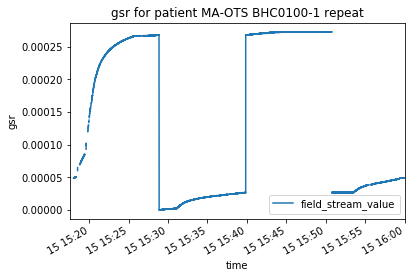

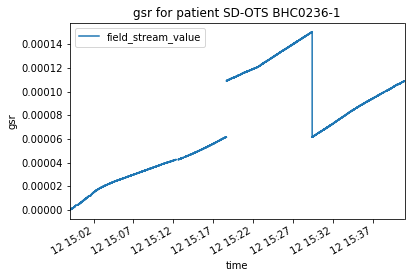

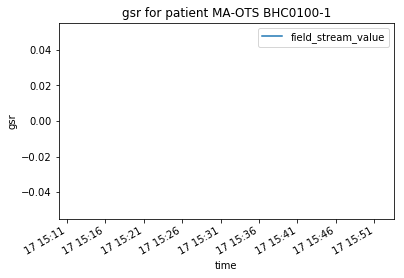

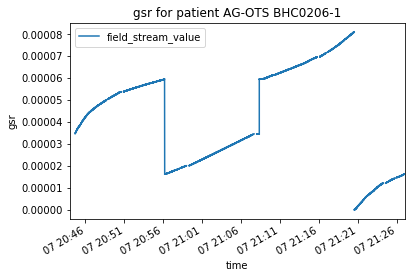

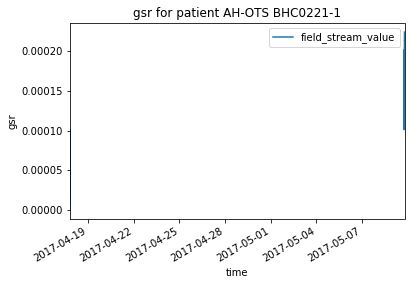

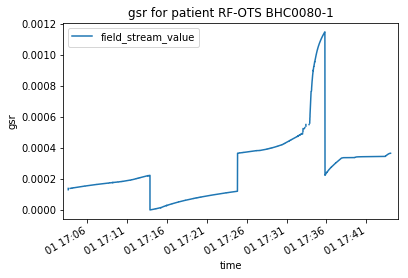

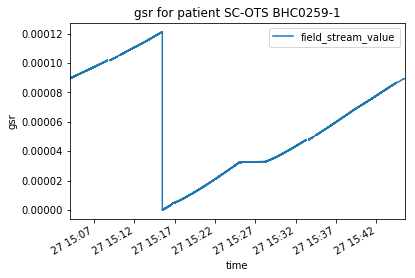

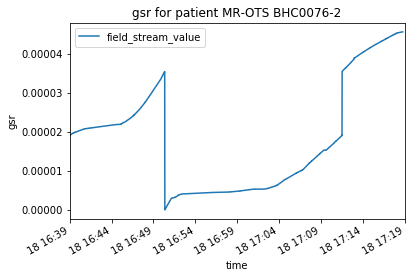

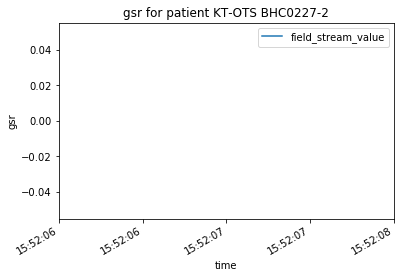

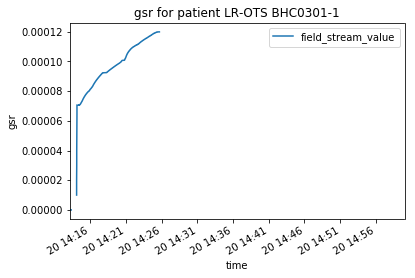

In [875]:
# try to plot gsr time series

for patient in short_list_patients:
    single_patient = all_simband_data[all_simband_data.subject_id==patient][['parsed_ts','field_stream','field_stream_value']]
    single_patient_gsr = single_patient[single_patient.field_stream == 'gsr']
    single_patient_gsr.reset_index(drop=True, inplace=True)
    single_patient_gsr.set_index('parsed_ts', inplace=True)
    single_patient_gsr = single_patient_gsr.cumsum()
    single_patient_gsr.plot()
    plt.title('gsr for patient {}'.format(patient))
    plt.ylabel('gsr')
    plt.xlabel('time')

In [853]:
single_patient.columns

Index(['parsed_ts', 'field_stream', 'field_stream_value'], dtype='object')

In [868]:
test = single_patient[single_patient.field_stream == 'gsr']
test.reset_index(drop=True, inplace=True)
test.set_index('parsed_ts', inplace=True)
test = test.cumsum()

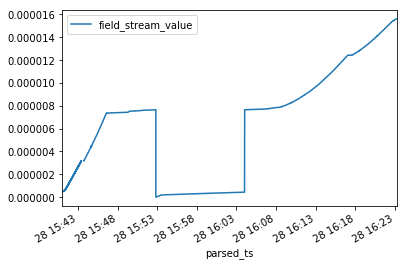

In [869]:
test.plot()